# Logistic Regression

The logistic regression hypothesis is defined as:

$h_\theta(x) = p(x) = g(\theta^Tx)$ where $g$ is the sigmoid function $ g(z) = \frac{1}{1+e^{-z}} $

$g$ models the relationship between $p(x) = Pr(y=1|x)$ and $x$. As you can see, the equation relating the two variables is clearly non linear (it has to be like that as we want $g$ to follow the constraints of a Cumulative Distribution Function, i.e. with outputs constrained between 0 and 1 and with an inflection point at 0.5). It is interesting to notice that logistic regression is by definition a linear model. In what is it actually linear?

Turns out that one can show the following:

$log(\frac{p(x)}{1 - p(x)}) = \theta^Tx$

The quantity $\frac{p(x)}{1 - p(x)}$ is called the $odds$. The previous manipulation shows that the logistic regression model has a logit (log-odds) which is linear in $x$.

The coefficients $\theta$ are unknown and must be estimated based on the available training data. In the linear regression context we used the least squares approach, minimizing $J(\theta) = \frac{1}{2m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)})^2 $. Within the logistic regression framework we need to do the same but we actually can't use the identical cost function definition as before, due to it not being convex (i.e. it would have many local minima). Hence we turn to the more general $maximum$ $likelihood$ method. This is the basic intuition behind it: we seek estimates for $\theta$ such that the predicted probability $p(x)$ of success (assuming a binary classification problem) for each observation, corresponds as closely as possible to the observation’s actual status (success/failure). In other words, we try to find $\theta$ such that plugging
these estimates into the model for $p(x)$, yields a number close to one for all individuals who successed, and a number close to zero for all individuals who did not. This intuition can be formalized using a mathematical equation called a likelihood function (which we need to maximize):

$l(\theta) = \prod_{i:y_1=1}p(x_i) \prod_{i:y_1=0}(1-p(x_i)) $

Computing the negative log of the whole equation and rearranging the terms leads us to the final cost function for the logistic regression model (which we now need to minimize):

$J(\theta) = \frac{1}{m}\sum_{i=1}^m(-y_i log(h_i(\theta)) - (1-y_i)log(1-h_i(\theta)))$

At the end of the day we want to find $\theta$ so that $J(\theta)$ is minimized, or putting it differently its gradient is 0, where the gradient of the cost function with respect to $\theta$ is equal to

$\nabla_{\theta} J(\theta) = \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)}$ 

basically identical to the linear regression one, just with a different $h_{\theta}$

## Problem definition 

Suppose that you are the administrator of a university department and you want to determine each applicant's chance of admission based on their results on two exams. You have historical data from previous applicants that you can use as a training set for logistic regression. For each training example, you have the applicant's scores on two exams and the admissions decision.
Your task is to build a classification model that estimates an applicant's probability of admission based the scores from those two exams.

In [214]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

students_exams = pd.read_csv('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex2-005\\mlclass-ex2\ex2data1.txt', 
                            header=None,
                            names=['FirstExamScore', 'SecondExamScore', 'Results'])
students_exams['Admission'] = np.where(students_exams.Results==0, 'Not Admitted', 'Admitted')

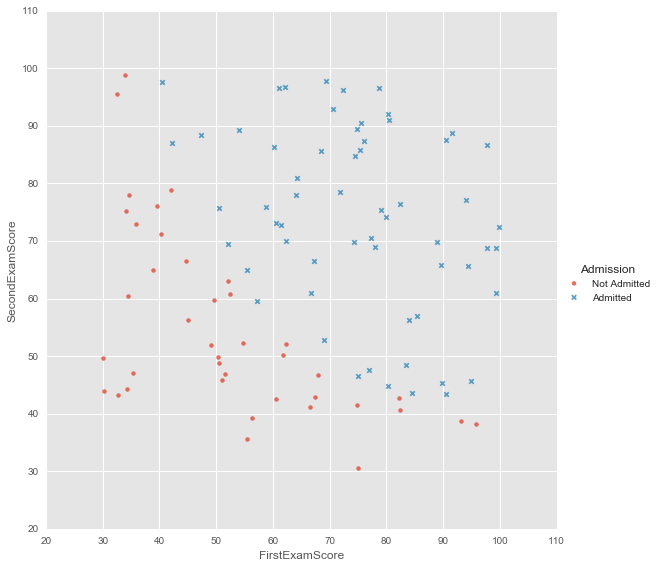

In [215]:
g = sns.lmplot("FirstExamScore", "SecondExamScore", hue="Admission", 
               data=students_exams, markers=["o", "x"], fit_reg=False, size=8)

### Functions

In [216]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

def computeCost(theta, X, y):
    m = y.shape[0]
    h_theta = sigmoid(X.dot(theta))

    cost = 1/m * (np.dot(np.log(h_theta).T, -y) + np.dot(np.log(1-h_theta).T, -(1-y))) 
    
    if np.isnan(cost):
        return np.inf
    
    return cost

def computeGradient(theta, X, y):
    theta = theta.reshape(-1, 1)
    m = y.shape[0]
    h_theta = sigmoid(X.dot(theta))
    
    gradient = 1/m * np.dot(X.T, h_theta - y)
    return gradient.flatten()

def plotDecisionBoundary(X, theta):
    plotx = np.array([min(X[:,1])-2, max(X[:,1])+2])
    ploty = -(theta[1] * plotx + theta[0])/theta[2]
    
    return plotx, ploty

def predict(X, theta):
    prob = sigmoid(X.dot(theta))
    p = np.where(prob < 0.5, 0, 1)
    
    return p.reshape(-1, 1)

### Running the Model

In [217]:
data = np.loadtxt('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex2-005\\mlclass-ex2\ex2data1.txt', delimiter=',')
X = data[:,0:2]
y = data[:,2]
y = y.reshape(y.shape[0], 1)
X = np.c_[np.ones(X.shape[0]), X] # adding column of ones to X to account for theta_0 (the intercept)
initial_theta = np.zeros((X.shape[1], 1))

from scipy import optimize
theta = optimize.fmin_bfgs(f=computeCost, x0=initial_theta, args=(X, y), fprime=computeGradient)

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 23
         Function evaluations: 28
         Gradient evaluations: 28


c:\users\pochetti\appdata\local\continuum\anaconda\envs\foodproject\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: divide by zero encountered in log


### Plotting Results

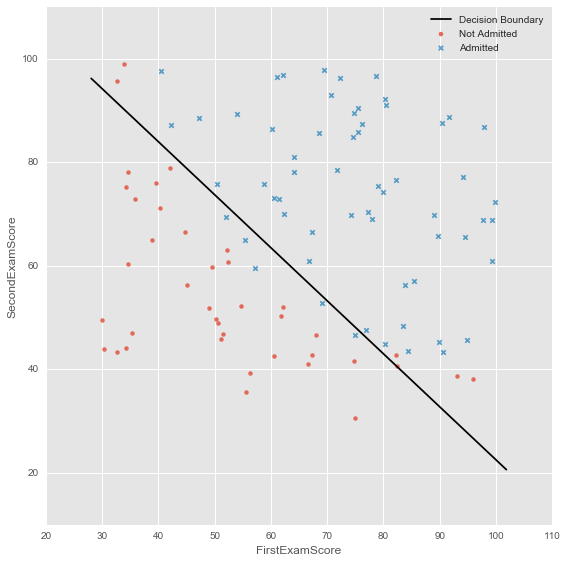

In [218]:
plotx, ploty= plotDecisionBoundary(X, theta)
g = sns.lmplot("FirstExamScore", "SecondExamScore", hue="Admission", 
               data=students_exams, markers=["o", "x"], fit_reg=False, size=8, legend=False)
ax = g.ax
ax.plot(plotx, ploty, color='k', label='Decision Boundary')
legend = ax.legend(loc=1, shadow=True)
plt.show()

### Calculating Model Accuracy

In [219]:
print('Model Accuracy: ',  ((y == predict(X, theta)).sum()/y.shape[0]) * 100, '%')

Model Accuracy:  89.0 %


## Regularized Logistic Regression

### Problem Definition

We will implement regularized logistic regression to predict whether microchips from a fabrication plant passes quality assurance (QA). During QA, each microchip goes through various tests to ensure it is functioning correctly.
Suppose you are the product manager of the factory and you have the test results for some microchips on two different tests. From these two tests, you would like to determine whether the microchips should be accepted or rejected. To help you make the decision, you have a dataset of test results on past microchips, from which you can build a logistic regression model.

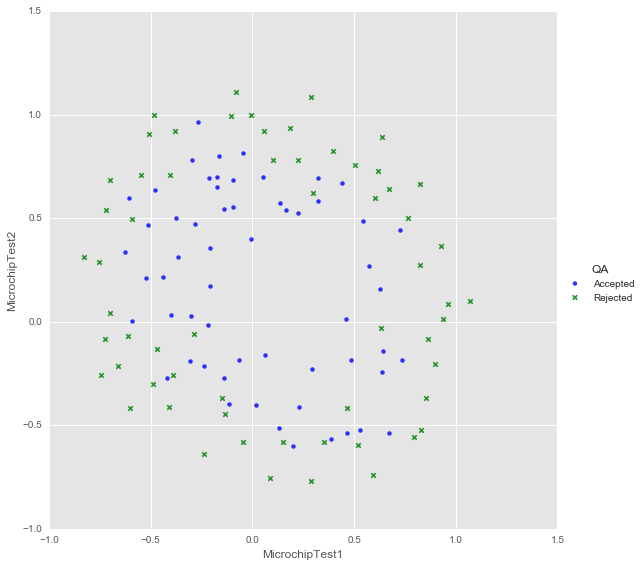

In [220]:
microchips = pd.read_csv('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex2-005\\mlclass-ex2\ex2data2.txt', 
                            header=None,
                            names=['MicrochipTest1', 'MicrochipTest2', 'Results'])
microchips['QA'] = np.where(microchips.Results==0, 'Rejected', 'Accepted')

g = sns.lmplot("MicrochipTest1", "MicrochipTest2", hue="QA", 
               data=microchips, markers=["o", "x"], fit_reg=False, size=8, palette=dict(Rejected="g", Accepted="b"))

It is very clear that the decision boundary is not linear. Logistic Regression as we implemented it above would miserably fail in this context. We need to move away from linearity in order to solve the microchips QA's problem. In order to achieve that we will add a bunch of features combining the 2 test scores into all their polynomial terms up to the sixth power. Doing so we take care of the low bias of the model, but we will also introduce inevitably much more variance. We will combat this second term using regularization. 

Applying a regularization terms the cost function looks like this:

$J(\theta) = \frac{1}{m}\sum_{i=1}^m(-y_i log(h_i(\theta)) - (1-y_i)log(1-h_i(\theta))) + \frac{\lambda}{2m}\sum_{j=1}^n\theta_j^2$

we need to keep in mind that the we don't have to regularize $\theta_0$, which refers to the first feature we artificially set to 1. Hence the gradient of the cost will look like the following

$\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)} $ for $j=0$

$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) x_j^{(i)} + \frac{\lambda}{m}\sum_{j=1}^n\theta_j$ for $j\geq1$

### Functions

In [221]:
def mapFeature(X1, X2, degree):
    """ MAPFEATURE Feature mapping function to polynomial features

    MAPFEATURE(X1, X2) maps the two input features
    to quadratic features used in the regularization exercise.

    Returns a new feature array with more features, comprising of 
    X1, X2, X1.^2, X2.^2, X1*X2, X1*X2.^2, etc..

    Inputs X1, X2 must be the same size"""
    
    X = np.ones(X1.shape[0])
    for i in np.arange(degree)+1:
        for j in np.arange(i+1):
            X = np.c_[X, np.power(X1, i-j) * np.power(X2, j)]
    return X

def computeCostReg(theta, X, y, lamb):
    m = y.shape[0]
    h_theta = sigmoid(X.dot(theta))

    cost = 1/m * (np.dot(np.log(h_theta).T, -y) + np.dot(np.log(1-h_theta).T, -(1-y))) + (lamb/2*m) * theta[1:,].T.dot(theta[1:,])
    
    return np.asscalar(cost.squeeze())

def computeGradientReg(theta, X, y, lamb):
    theta = theta.reshape(-1, 1)
    m = y.shape[0]
    h_theta = sigmoid(X.dot(theta))
    
    gradient = 1/m * np.dot(X.T, h_theta - y)
    gradient[1:] += lamb/m * theta[1:,]
    
    return gradient.flatten()

def plotDecisionBoundaryReg(X, theta, ax):
    # generating an evenly spaced grid to evaluate the classifier's predictions
    u = np.linspace(-1, 1.5, 50)
    v = np.linspace(-1, 1.5, 50)
    
    z = np.zeros((len(u), len(v)));
    # Evaluate z = theta*x over the grid
    for i in np.arange(len(u)):
        for j in np.arange(len(v)):
            z[i,j]= np.dot(mapFeature(np.atleast_1d(u[i]).reshape(-1,1), np.atleast_1d(v[j]).reshape(-1,1), 6), theta.x)
    
    cs = ax.contour(u, v, z.T, linewidth=4, levels=[0], colors='k')
    plt.clabel(cs,  
               inline=1,
               fmt='%1.2f',
               fontsize=14)
    plt.show()
    return z

### Running the model

In [222]:
data = np.loadtxt('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex2-005\\mlclass-ex2\ex2data2.txt', delimiter=',')
X = data[:,0:2]
y = data[:,2]
y = y.reshape(y.shape[0], 1)

# mapping features into all polynomial terms of X1 and X2 up to the sixth power
X_expanded = mapFeature(X[:,0], X[:,1], 6)

initial_theta = np.zeros((X_expanded.shape[1], 1))
#initial_theta = np.random.rand(X_expanded.shape[1], 1)

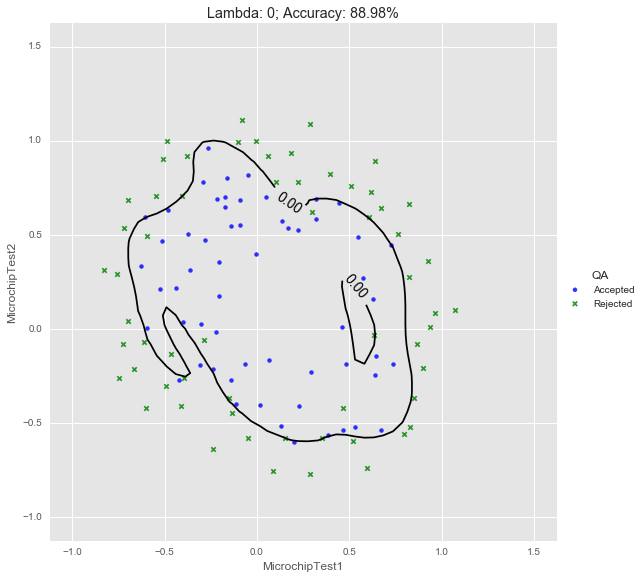

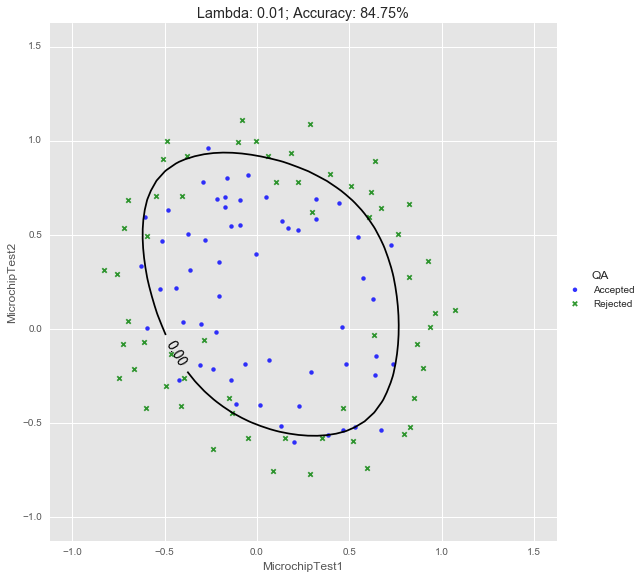

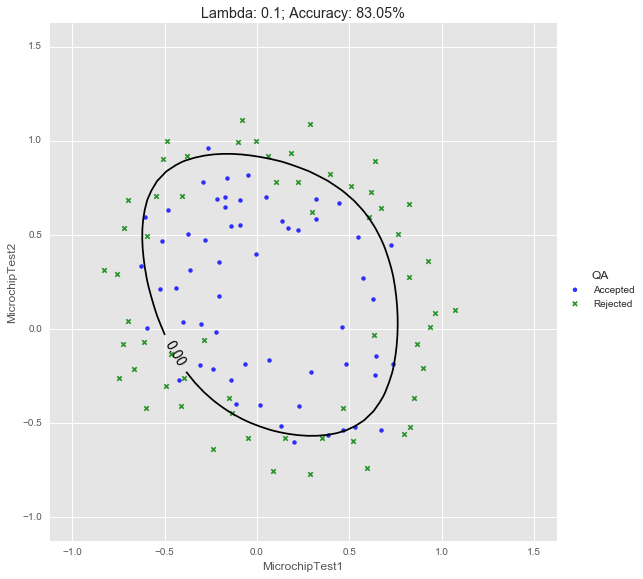

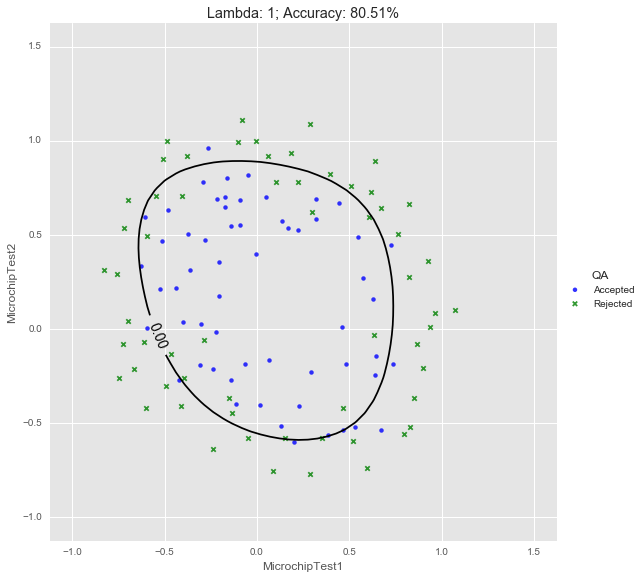

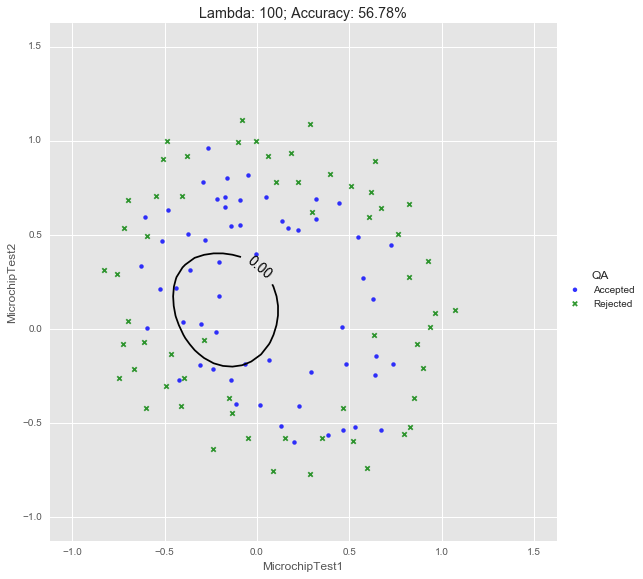

In [223]:
for lamb in [0, 0.01, 0.1, 1, 100]:
    theta = optimize.minimize(fun=computeCostReg, x0=initial_theta.squeeze(), args=(X_expanded, y, lamb),
                          method='TNC', jac=computeGradientReg, options=dict(disp=True, maxiter=100000))

    g = sns.lmplot("MicrochipTest1", "MicrochipTest2", hue="QA", 
                   data=microchips, markers=["o", "x"], fit_reg=False, size=8, palette=dict(Rejected="g", Accepted="b"))
    ax = g.ax
    accuracy = ((y == predict(X_expanded, theta.x)).sum()/y.shape[0])*100
    ax.set_title('Lambda: {0}; Accuracy: {1}%'.format(lamb, round(accuracy, 2)))
    z = plotDecisionBoundaryReg(X, theta, ax)

### Appendix: How to estimate the gradient of the cost, given the cost function

Let's say we have both the cost and the gradient functions but we need to somehow debug the latter, as we are already sure the first is correct. This can be quite challenging if we don't have a benchmark. Turns out that there is a math trick which does the job pretty well.

It suffices to re-surface from our calculus courses the definition of derivative w.r.t. a variable and we can write down the following

$\frac{\partial J(\theta)}{\partial \theta_j} = \frac{J(\theta_j + \epsilon) - J(\theta_j)}{\epsilon}$ with $\epsilon$ arbitrarily small

This is actually already implemented in scipy, with the check_grad function.

In [224]:
from scipy.optimize import check_grad

check_grad(computeCostReg, computeGradientReg, initial_theta.squeeze(), X_expanded, y, lamb)

0.00045679018542622569

The error is pretty small!

# Multi Class Classification

In [225]:
import scipy.io
import random

mat = scipy.io.loadmat('C:\\Users\\pochetti\Machine_Learning\\mlclass-ex3-005\\mlclass-ex3\ex3data1.mat')
X = mat['X']
y = mat['y']

## Functions

In [255]:
def displayData(X):
    fig = plt.figure(figsize=(8,8))
    plt.title('100 Random Images from the data set')
    indexes = random.sample(range(1, X.shape[0]), 100)
    images = X[indexes,:]
    for i in np.arange(10):
        for j in np.arange(10):
            ax = fig.add_subplot(10, 10, (10*j+i)+1)
            ax.matshow(images[10*j+i,:].reshape(20,20), cmap = 'gray')
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.show()
    
def oneVsAll(X, y, num_labels, lamb):
    m = X.shape[0]
    n = X.shape[1]

    all_theta = np.zeros((num_labels, n + 1))

    X = np.c_[np.ones(m), X]
    for c in np.arange(num_labels):
        initial_theta = np.zeros((n + 1, 1))
    
        theta = optimize.minimize(fun=computeCostReg, x0=initial_theta.squeeze(), args=(X, y==c+1, lamb),
                                  method='TNC', jac=computeGradientReg, options=dict(disp=True, maxiter=100000))
   
        all_theta[c,:] = theta.x
    
    return all_theta

def predictOneVsAll(theta, X):
    X = np.c_[np.ones(X.shape[0]), X]
    
    return sigmoid(X.dot(theta.T))

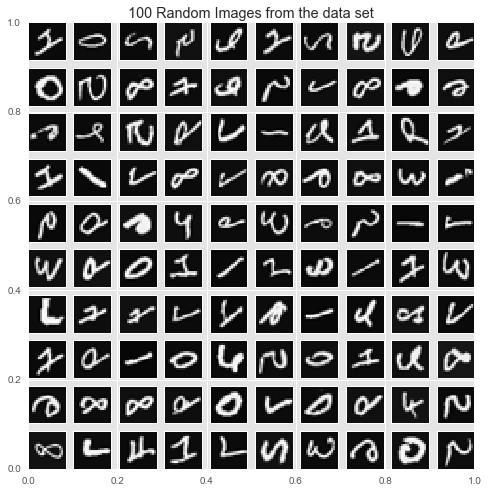

In [248]:
displayData(X)

In [272]:
# running one logistic Regression per class and getting different thetas per class
all_theta = oneVsAll(X, y, 10, 0.01)

# calculating probabilities applying the sigmoid function
probabilities = predictOneVsAll(all_theta, X)

# getting predictions
predictions = np.argmax(pred, axis=1) + 1

# calculating accuracy
accuracy = ((y == predictions.reshape(-1,1)).sum()/y.shape[0])*100
'Accuracy: {0}%'.format(round(accuracy, 2))

c:\users\pochetti\appdata\local\continuum\anaconda\envs\foodproject\lib\site-packages\ipykernel\__main__.py:22: DeprecationWarning: numpy boolean negative, the `-` operator, is deprecated, use the `~` operator or the logical_not function instead.


'Accuracy: 73.06%'